<a href="https://colab.research.google.com/github/DavidJimenez10/CV-Deep-Learning/blob/main/original_leukemia_color_segmentation_with_RF_and_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
"""
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [ ]:
pip install imutils

  Preparing metadata (setup.py) ... done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=caf4e4e4030ac5339d06c2e371b076aa734dfe07df35f6d801e34dfad06592ae
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#Core
import cv2
import numpy as np
from matplotlib import pyplot as plt
import matplotlib

#Utils
import os
from glob import glob
from imutils import paths, grab_contours

#Grain size analysis
from scipy import ndimage
from skimage import io, color, measure
from skimage.feature import peak_local_max
from skimage.segmentation import watershed

#Pre-processing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, RepeatedKFold
from scipy.stats import loguniform

#Image augmentation
from skimage.transform import rotate
from skimage.util import random_noise
import random

#XGBoost
import xgboost as xgb


In [ ]:
#Load first 100 images in an indicated color space
def load_category(path, color_space):
    folder= sorted(glob(path))[:100]
    list_category = []
    for file in folder:
        img = cv2.imread(file)
        list_category.append(cv2.cvtColor(img, color_space))
    print(folder[0])
    return np.array(list_category, dtype=np.uint8)

In [ ]:
#Show a sample of 9 images
def show_samples(arr_category,random_choice=None, binary_segmentation=False):
    
    if random_choice is None:
        len_array = arr_category.shape[0]
        random_choice = np.random.choice(len_array,9, replace=False)
        
    fig = plt.figure(figsize=(12,12))
    for i,sample in enumerate(random_choice):
        ax = fig.add_subplot(3, 3, i+1)
        if binary_segmentation:
            img = cv2.threshold(arr_category[sample,:,:],0,255,cv2.THRESH_OTSU)[1]
        else:
            img = arr_category[sample,:,:,:]
        imgplot = plt.imshow(img)
        ax.set_title(f'sample {i}')
    
    return random_choice


In [ ]:
def random_choice(arr_category,sample_size):
    len_array = arr_category.shape[0]
    random_choice = np.random.choice(len_array,sample_size, replace=False)
    return arr_category[random_choice]

In [ ]:
#Show a sample of 9 images
def show_samples(arr_category):
        
    fig = plt.figure(figsize=(12,12))
    for i,sample in enumerate(arr_category):
        ax = fig.add_subplot(3, 3, i+1)
        imgplot = plt.imshow(sample)
        ax.set_title(f'sample {i}')

In [ ]:
#Plot the histogram of colors in a array
def plot_mean_hist(arr_category, color_space, ch1, ch2, ch3):
    mean_ch1 = arr_category[:,:,:,0]
    mean_ch2 = arr_category[:,:,:,1]
    mean_ch3 = arr_category[:,:,:,2]
    fig, axs = plt.subplots(3, figsize=(10,10))
    fig.suptitle(f'Mean histrogram {color_space}')
    axs[0].hist(mean_ch1.flat, bins=100, range=(0,256))
    axs[0].set_title(ch1)
    axs[1].hist(mean_ch2.flat, bins=100, range=(0,256))
    axs[1].set_title(ch2)
    axs[2].hist(mean_ch3.flat, bins=100, range=(0,256))
    axs[2].set_title(ch3)
    plt.show()

In [ ]:
def binary_segmentation(arr_category):
    img_segmented = []
    for sample in arr_category:
        #img_segmented.append(cv2.threshold(sample,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1])
        
        #img_otsu = cv2.bitwise_and(sample,sample, mask= cv2.threshold(sample,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1])
        #img_otsu = cv2.threshold(img_otsu,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
        #img_segmented.append(img_otsu)
        
        img_segmented.append(cv2.adaptiveThreshold(sample,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,57,-8))
    return np.array(img_segmented, dtype=np.uint8)

In [ ]:
def erode_dilation(arr_category, kernel, iter_ero, iter_dil):
    img_process = []
    for img in arr_category:
        img_erode = cv2.erode(img, kernel, iterations=iter_ero)
        img_dilation = cv2.dilate(img_erode, kernel, iterations=iter_dil)
        img_process.append(img_dilation)
    return np.array(img_process, dtype=np.uint8)

In [ ]:
def apply_mask(arr_category, arr_mask):
    img_masked = []
    for img, mask in zip(arr_category, arr_mask):
        img_masked.append(cv2.bitwise_and(img,img, mask= mask))
        
    return np.array(img_masked, dtype=np.uint8)

In [ ]:
def load_dataset(root_folder, image_size):
    images_paths = list(paths.list_images(root_folder))
    encoder = LabelEncoder()    
    
    x = []
    y = []
    
    for image in images_paths:
        x.append(cv2.imread(image))
        y.append(image.replace(root_folder,'').rsplit('/')[0])

    y = encoder.fit_transform(y)
    return np.array(x),y, list(encoder.classes_)

In [ ]:
def dataset_lab(dataset):
    lab_dataset = []
    for img in dataset:
        lab_dataset.append(cv2.cvtColor(img, cv2.COLOR_BGR2LAB))
    return np.array(lab_dataset)

In [ ]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

## Looking Pro
### RGB

In [ ]:
arr_pro_rgb = load_category('/kaggle/input/leukemia/Original/Pro/*.jpg', cv2.COLOR_BGR2RGB)

/kaggle/input/leukemia/Original/Pro/WBC-Malignant-Pro-001.jpg


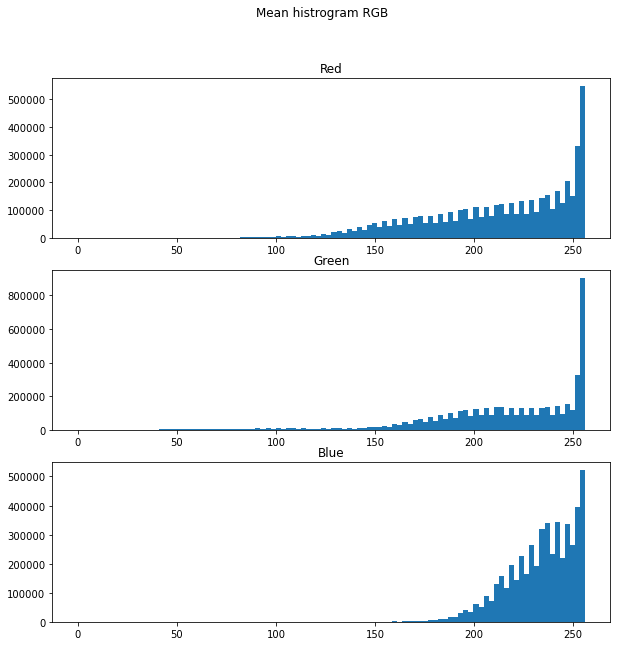

In [ ]:
plot_mean_hist(arr_pro_rgb, "RGB", "Red", "Green", "Blue")

In [ ]:
arr_pro_lab = load_category('/kaggle/input/leukemia/Original/Pro/*.jpg', cv2.COLOR_BGR2LAB)

/kaggle/input/leukemia/Original/Pro/WBC-Malignant-Pro-001.jpg


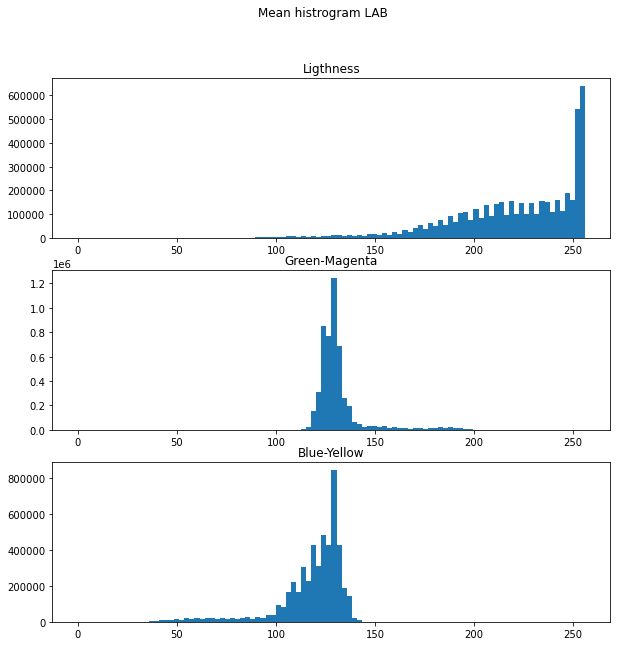

In [ ]:
plot_mean_hist(arr_pro_lab, "LAB", "Ligthness", "Green-Magenta", "Blue-Yellow")

In [ ]:
lab_sub_set = random_choice(arr_pro_lab,9)
rgb_sub_set = []
for img in lab_sub_set:
    rgb_sub_set.append(cv2.cvtColor(img, cv2.COLOR_LAB2RGB))
rgb_sub_set = np.array(rgb_sub_set)

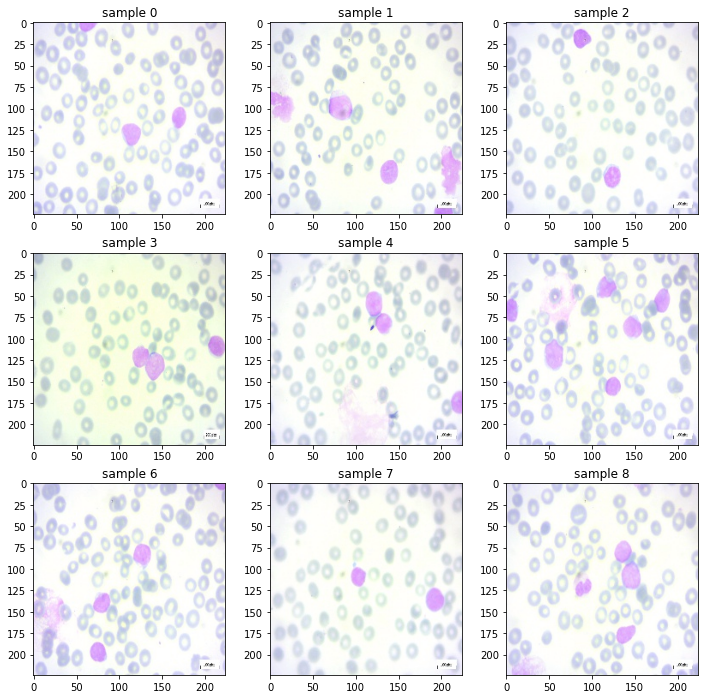

In [ ]:
show_samples(rgb_sub_set)

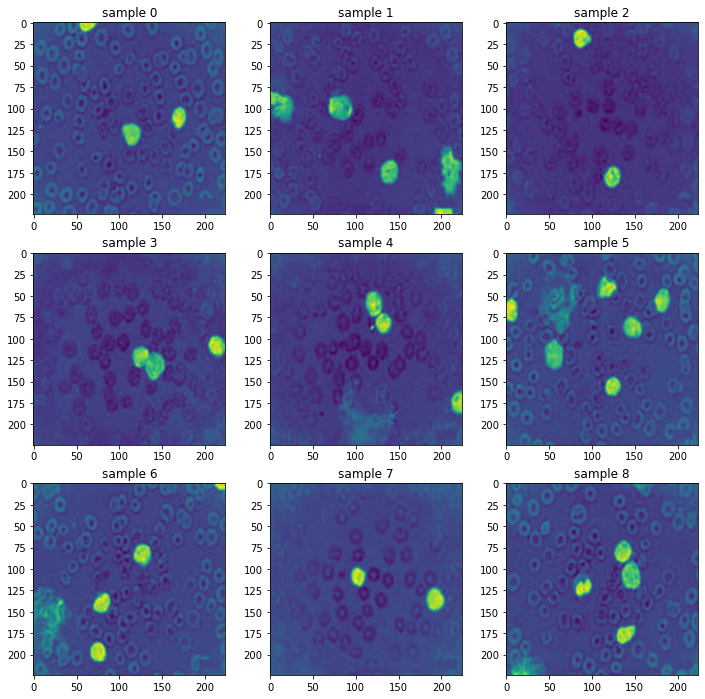

In [ ]:
show_samples(lab_sub_set[:,:,:,1])

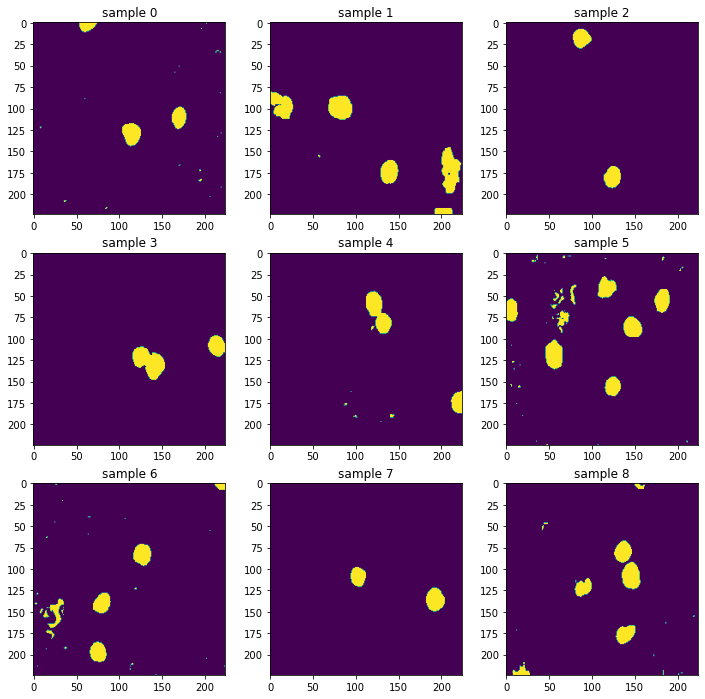

In [ ]:
show_samples(binary_segmentation(lab_sub_set[:,:,:,1]))

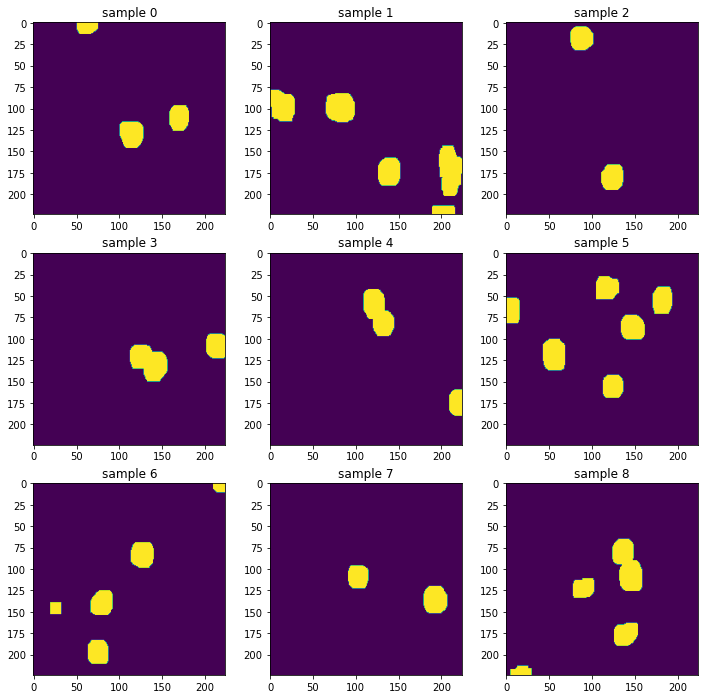

In [ ]:
iter_erode = 3
iter_dilate = iter_erode * 2 
show_samples(erode_dilation(binary_segmentation(lab_sub_set[:,:,:,1]),np.ones((3,3),np.uint8),iter_erode, iter_dilate))

In [ ]:
def get_watershed_labels(arr_category, min_distance):
    ws_labels = []
    for sample in arr_category:
        D = ndimage.distance_transform_edt(sample)
        local_max = peak_local_max(D, indices=False, min_distance=min_distance, labels=sample)
        
        markers = ndimage.label(local_max, structure=np.ones((3,3)))[0]
        labels = watershed(-D, markers, mask=sample)
        ws_labels.append(labels)
    
    return ws_labels

In [ ]:
def draw_watershed(arr_category, arr_binary, min_distance):
    # loop over the unique labels returned by the Watershed
    # algorithm
    arr_category_copy = arr_category.copy()
    img_segmented_ws = []
    arr_labels = get_watershed_labels(arr_binary, min_distance)
    contour_areas = []
    for image, labels in zip(arr_category_copy, arr_labels):
        contour_areas_image = []
        print('-'*50)
        for label in np.unique(labels):
            # if the label is zero, we are examining the 'background'
            # so simply ignore it
            if label == 0:
                continue
            # otherwise, allocate memory for the label region and draw
            # it on the mask
            mask = np.zeros(image.shape[0:2], dtype="uint8")
            mask[labels == label] = 255
            # detect contours in the mask and grab the largest one
            cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
                cv2.CHAIN_APPROX_SIMPLE)
            cnts = grab_contours(cnts)
            c = max(cnts, key=cv2.contourArea)
            print(cv2.contourArea(c))
            contour_areas_image.append(cv2.contourArea(c))
            # draw a circle enclosing the object
            #((x, y), r) = cv2.minEnclosingCircle(c)
            #cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
            #cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
            #cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
        contour_areas.append(contour_areas_image)
        img_segmented_ws.append(image)
    return np.array(contour_areas), img_segmented_ws

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


--------------------------------------------------
282.5
572.0
713.0
--------------------------------------------------
850.5
962.0
1217.5
729.0
--------------------------------------------------
612.0
643.0
--------------------------------------------------
555.0
532.5
738.0
--------------------------------------------------
681.5
561.5
381.0
0.0
--------------------------------------------------
605.0
619.5
0.0
416.0
677.0
369.0
430.5
548.5
--------------------------------------------------
673.0
618.0
156.0
582.5
--------------------------------------------------
544.0
736.0
--------------------------------------------------
599.0
805.5
477.5
609.5
0.5
198.5


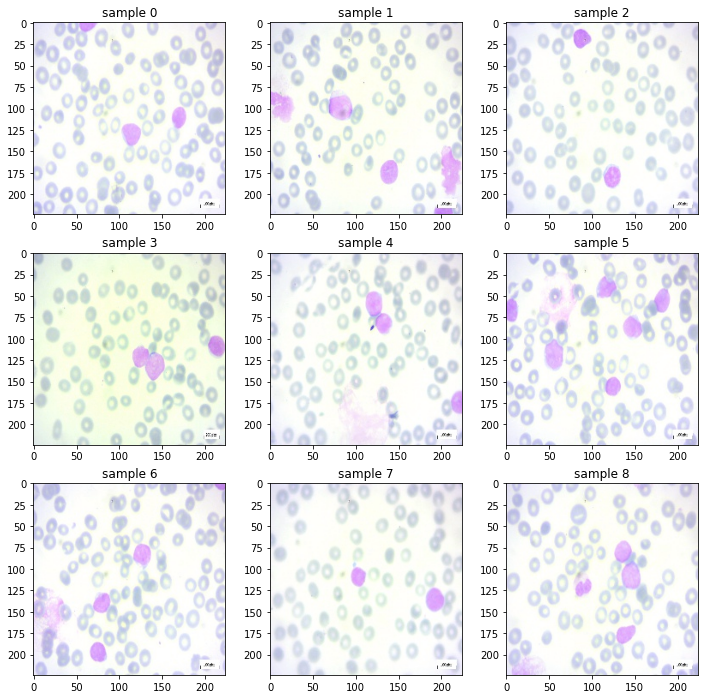

In [ ]:
eroded_set = erode_dilation(binary_segmentation(lab_sub_set[:,:,:,1]),np.ones((3,3),np.uint8),iter_erode, iter_dilate)
contour_areas, img_segmented_ws = draw_watershed(rgb_sub_set, eroded_set, 10)
show_samples(img_segmented_ws)

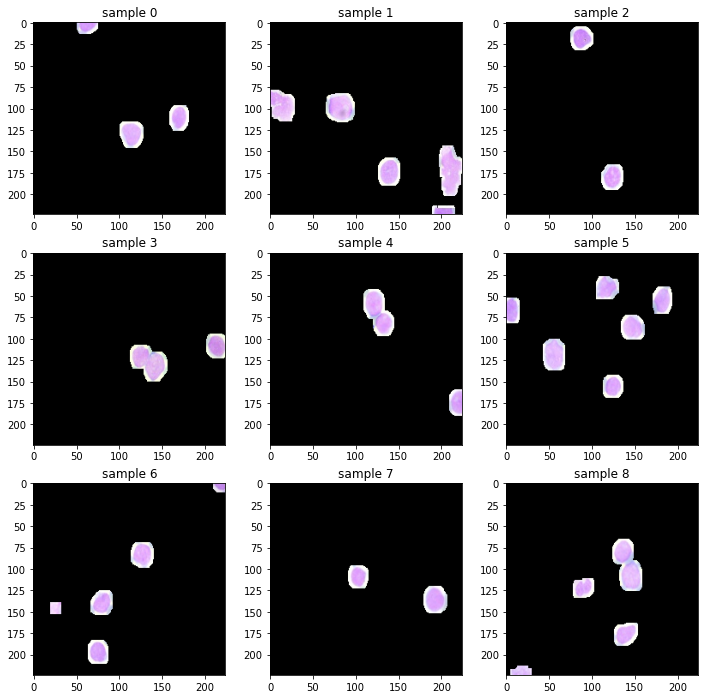

In [ ]:
show_samples(apply_mask(rgb_sub_set,eroded_set))

## Load data

In [ ]:
#The description dataset says "All the images were taken using a Zeiss camera in a microscope with 100x magnification" according to https://openwetware.org/wiki/Methods_to_determine_the_size_of_an_object_in_microns
PIXEL_TO_UM = 0.0645 #1 pixel = 0.0645 um or 15.50 pixels/um
#Lymphocytes are one of the smallest types of white blood cells and measure approximately 14 to 20 micrometers (https://www.quora.com/What-is-the-size-of-white-blood-cells)
#So 15 um /  = 
ITER_ERODE = 3
ITER_DILATION = ITER_ERODE*2

In [ ]:
x, y, encoder = load_dataset("/kaggle/input/leukemia/Original/", (1,224,224))
print(encoder)
print('x shape:', x.shape)
print('y shape:', y.shape)

['Benign', 'Early', 'Pre', 'Pro']
x shape: (3256, 224, 224, 3)
y shape: (3256,)


## Pre-Processing

In [ ]:
x_lab = dataset_lab(x)
x_binary_a_channel = binary_segmentation(x_lab[:,:,:,1])
ero_dil_x = erode_dilation(x_binary_a_channel, np.ones((3,3)), ITER_ERODE, ITER_DILATION)
x_preproced = apply_mask(x, ero_dil_x)

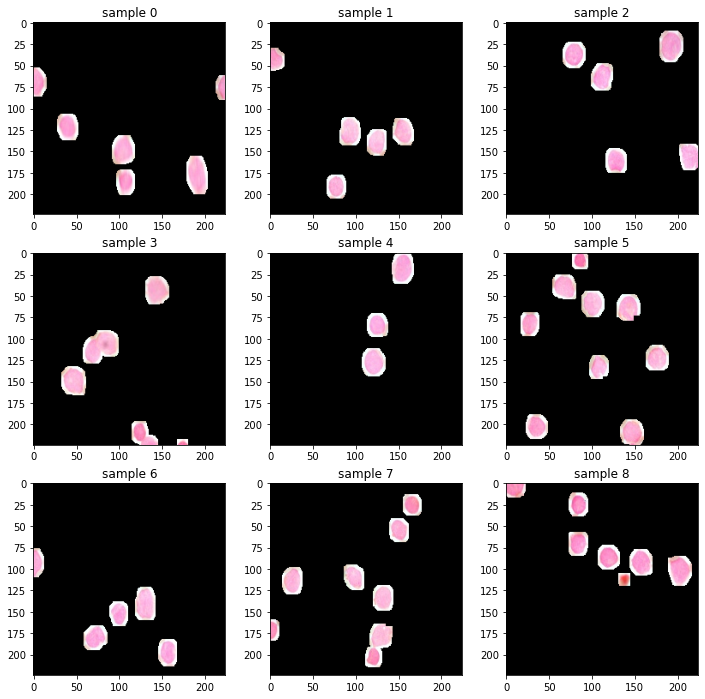

In [ ]:
show_samples(x_preproced[:9])

## Splitting data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x_preproced/255.0 , y, test_size=0.3, random_state=0)

### Random Forest Baseline

In [ ]:
rf_classifier = RandomForestClassifier(random_state=0)#n_estimators=50, max_features='auto', 
rf_classifier.fit(X_train.reshape((X_train.shape[0],-1)), y_train)

#### Random Forest Evaluation
**Confusion Matrix**

In [ ]:
y_pred = rf_classifier.predict(X_test.reshape((X_test.shape[0],-1)))

In [ ]:
rf_confusion_matrix = confusion_matrix(y_test,y_pred)

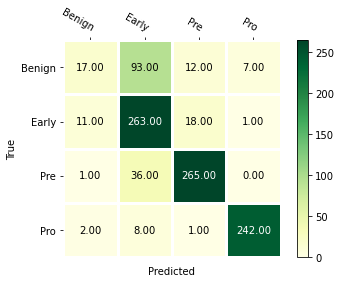

In [ ]:
im,cbar = heatmap(rf_confusion_matrix,encoder,encoder, cmap='YlGn')
plt.xlabel('Predicted')
plt.ylabel('True')
texts = annotate_heatmap(im)

**Metrics**

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.13      0.21       129
           1       0.66      0.90      0.76       293
           2       0.90      0.88      0.89       302
           3       0.97      0.96      0.96       253

    accuracy                           0.81       977
   macro avg       0.77      0.72      0.71       977
weighted avg       0.80      0.81      0.78       977



### Random Forest Randomized Tuning

In [ ]:
criterion = ["gini", "entropy", "log_loss"]
n_estimators = list(range(1,int(X_train.shape[0]/len(encoder)),5))
min_samples_leaf = list(range(1,50))
max_features = ["log2","sqrt"]
rf_grid = dict(criterion=criterion, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf, max_features=max_features)

rf_classifier = RandomForestClassifier(random_state=0)

In [ ]:
rf_cvFold = RepeatedKFold(n_splits=10, n_repeats=3, random_state=0)
rf_randomSearch = RandomizedSearchCV(estimator=rf_classifier, n_jobs=-1, cv=rf_cvFold, param_distributions=rf_grid, scoring="f1_macro")
rf_randomSearch.fit(X_train.reshape((X_train.shape[0],-1)), y_train)
print(rf_randomSearch.best_params_)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 1041, in __call__
    if self.dispatch_one_batch(iterator):
  File "/opt/conda/lib/python3.7/site-packages/joblib/par

{'n_estimators': 156, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'criterion': 'entropy'}


**Confusion Matrix**

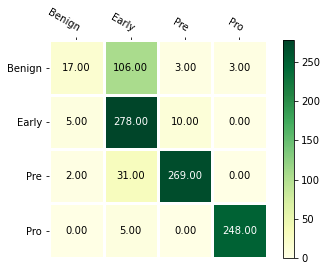

In [ ]:
y_pred = rf_randomSearch.predict(X_test.reshape((X_test.shape[0],-1)))
rf_confusion_matrix = confusion_matrix(y_test,y_pred)
im,cbar = heatmap(rf_confusion_matrix,encoder,encoder, cmap='YlGn')
plt.xlabel('Predicted')
plt.ylabel('True')
texts = annotate_heatmap(im)

**Metrics**

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.13      0.22       129
           1       0.66      0.95      0.78       293
           2       0.95      0.89      0.92       302
           3       0.99      0.98      0.98       253

    accuracy                           0.83       977
   macro avg       0.83      0.74      0.73       977
weighted avg       0.84      0.83      0.80       977



### XGBoost Baseline

In [ ]:
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(X_train.reshape((X_train.shape[0],-1)), y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

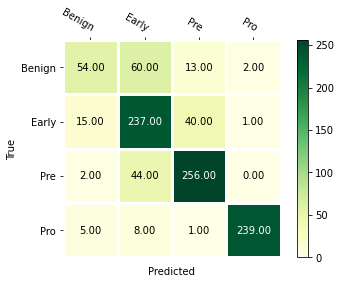

In [ ]:
y_pred = xgb_classifier.predict(X_test.reshape((X_test.shape[0],-1)))
xgb_confusion_matrix = confusion_matrix(y_test, y_pred)
im,cbar = heatmap(xgb_confusion_matrix,encoder,encoder, cmap='YlGn')
plt.xlabel('Predicted')
plt.ylabel('True')
texts = annotate_heatmap(im)

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.71      0.42      0.53       129
           1       0.68      0.81      0.74       293
           2       0.83      0.85      0.84       302
           3       0.99      0.94      0.97       253

    accuracy                           0.80       977
   macro avg       0.80      0.75      0.77       977
weighted avg       0.81      0.80      0.80       977

